# Titanic 数据分析与预测

In [96]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
plt.rcParams['font.sans-serif']=['Songti SC']
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 一、数据查看

In [114]:
df = sns.load_dataset("titanic")

In [18]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


### object类型值（分类变量）统计

In [48]:
df.describe(include=[np.object])

,sex,embarked,who,embark_town,alive
count,891,889,891,889,891
unique,2,3,3,3,2
top,male,S,man,Southampton,no
freq,577,644,537,644,549


### 不同pclass占比

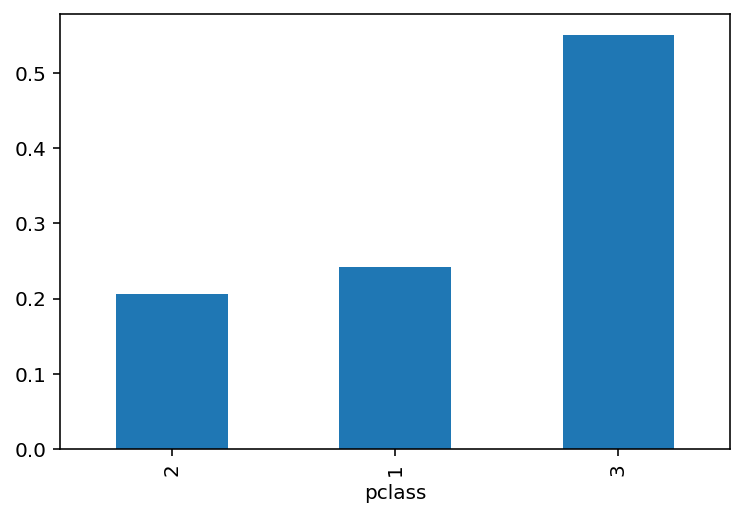

In [54]:
(df.groupby('pclass').size()/len(df)).sort_values().plot(kind='bar')

# 二、数据清洗

## 1.age根据sex分组取中位数进行补全

In [115]:
age_median = df.groupby('sex').age.median()
age_median

sex
female    27.0
male      29.0
Name: age, dtype: float64

In [116]:
df.set_index('sex',inplace=True)
df.age.fillna(age_median,inplace=True)
df.reset_index(inplace=True)

In [117]:
df.age.describe()

count    891.000000
mean      29.441268
std       13.018747
min        0.420000
25%       22.000000
50%       29.000000
75%       35.000000
max       80.000000
Name: age, dtype: float64

## 2.age根据sex和pclass分组，取中位数进行补全

In [124]:
df = sns.load_dataset("titanic")

In [125]:
age_median = df.groupby(['pclass','sex']).age.median()
age_median

pclass  sex   
1       female    35.0
        male      40.0
2       female    28.0
        male      30.0
3       female    21.5
        male      25.0
Name: age, dtype: float64

In [126]:
df.set_index(['pclass','sex'],inplace=True)
df.age.fillna(age_median,inplace=True)
df.reset_index(inplace=True)
df.age.describe()

count    891.000000
mean      29.112424
std       13.304424
min        0.420000
25%       21.500000
50%       26.000000
75%       36.000000
max       80.000000
Name: age, dtype: float64

### 3. sex和embark转为数字编码表示

In [127]:
df['sex']=df['sex'].map({'male':0,'female':1})

In [138]:
df['embarked'].fillna(df.groupby('embarked')['survived'].count().idxmax(),inplace=True)

In [139]:
df['embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [140]:
df['embarked'] = df['embarked'].map({'S':0,'C':1,'Q':2})

In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
pclass         891 non-null int64
sex            891 non-null int64
survived       891 non-null int64
age            891 non-null float64
sibsp          891 non-null int64
parch          891 non-null int64
fare           891 non-null float64
embarked       891 non-null int64
class          891 non-null category
who            891 non-null object
adult_male     891 non-null bool
deck           203 non-null category
embark_town    889 non-null object
alive          891 non-null object
alone          891 non-null bool
dtypes: bool(2), category(2), float64(2), int64(6), object(3)
memory usage: 80.6+ KB


# 三、数据探索

### 不同pclass的生还率

In [41]:
df[['pclass','survived']].groupby('pclass').mean()

,survived
pclass,
1,0.629630
2,0.472826
3,0.242363


In [44]:
df.pivot_table(values='survived',index='pclass',aggfunc=np.mean)

,survived
pclass,
1,0.629630
2,0.472826
3,0.242363


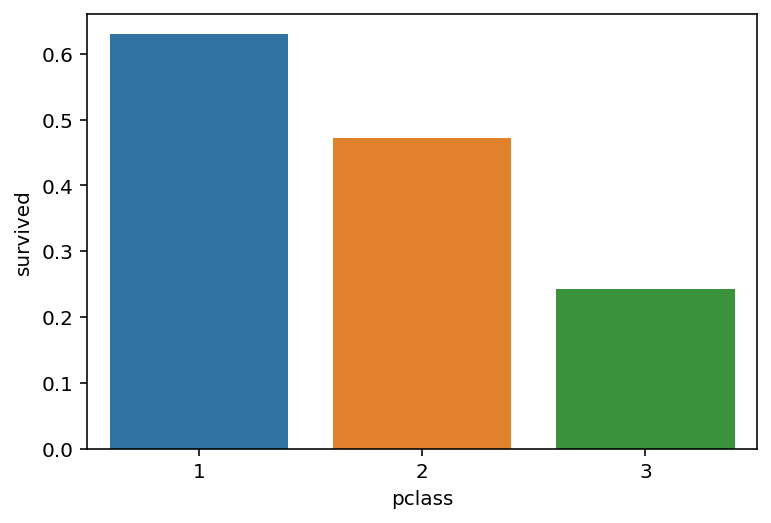

In [56]:
sns.barplot(x='pclass',y='survived',data=df,ci=None)

pclass越高生还率越高

### 不同性别生还率

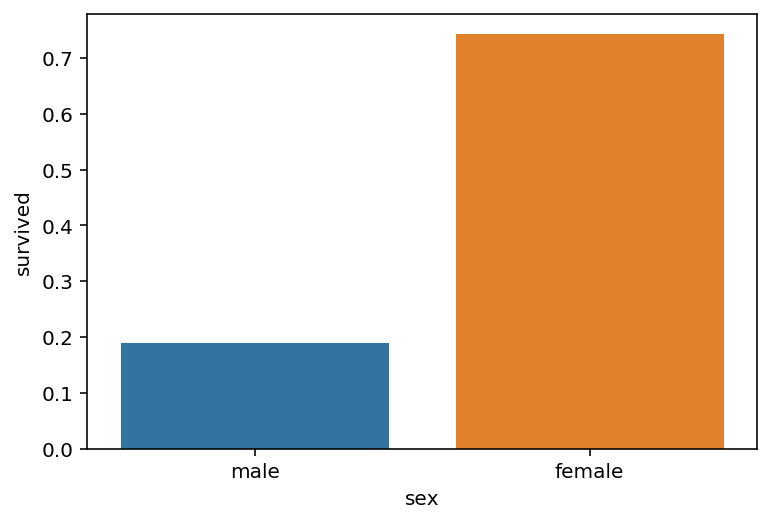

In [55]:
sns.barplot(x='sex',y='survived',data=df,ci=None)

female生还率高于male

### 综合pclass和sex的生还率

In [62]:
df.groupby(['pclass','sex']).survived.mean()
#df.pivot_table(values='survived',index=['pclass','sex'],aggfunc=np.mean)

pclass  sex   
1       female    0.968085
        male      0.368852
2       female    0.921053
        male      0.157407
3       female    0.500000
        male      0.135447
Name: survived, dtype: float64

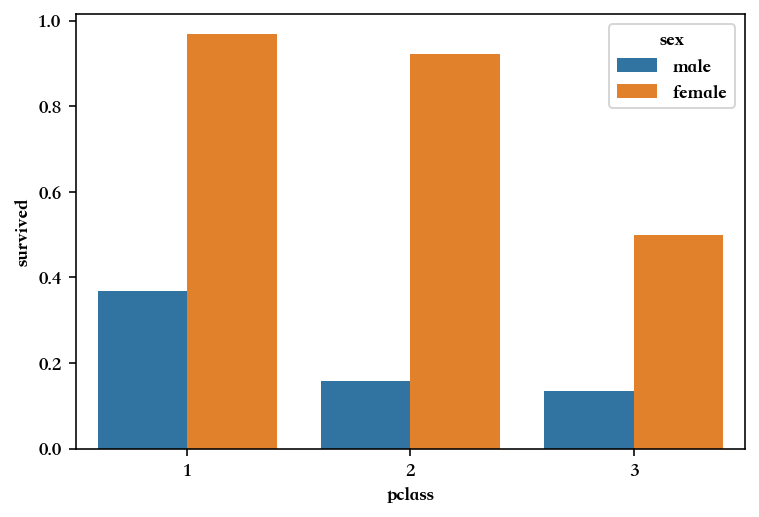

In [102]:
sns.barplot(data=df,y='survived',x='pclass',hue='sex',ci=None)

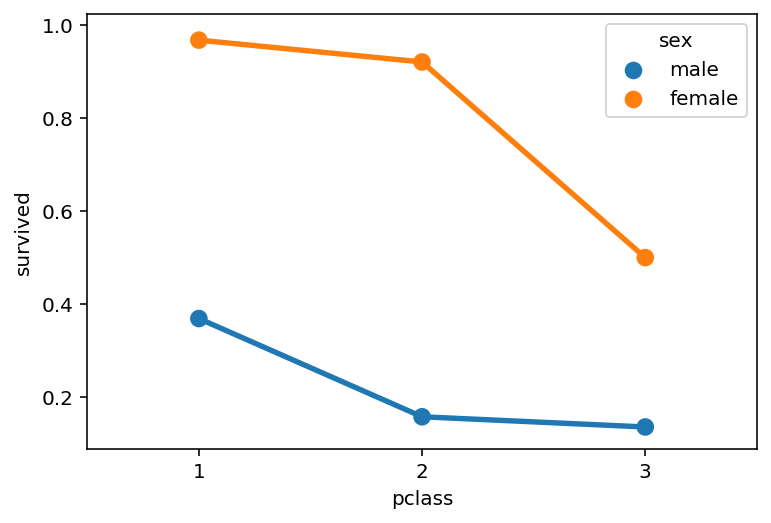

In [61]:
sns.pointplot(data=df,y='survived',x='pclass',hue='sex',ci=None)

### 年龄分布直方图

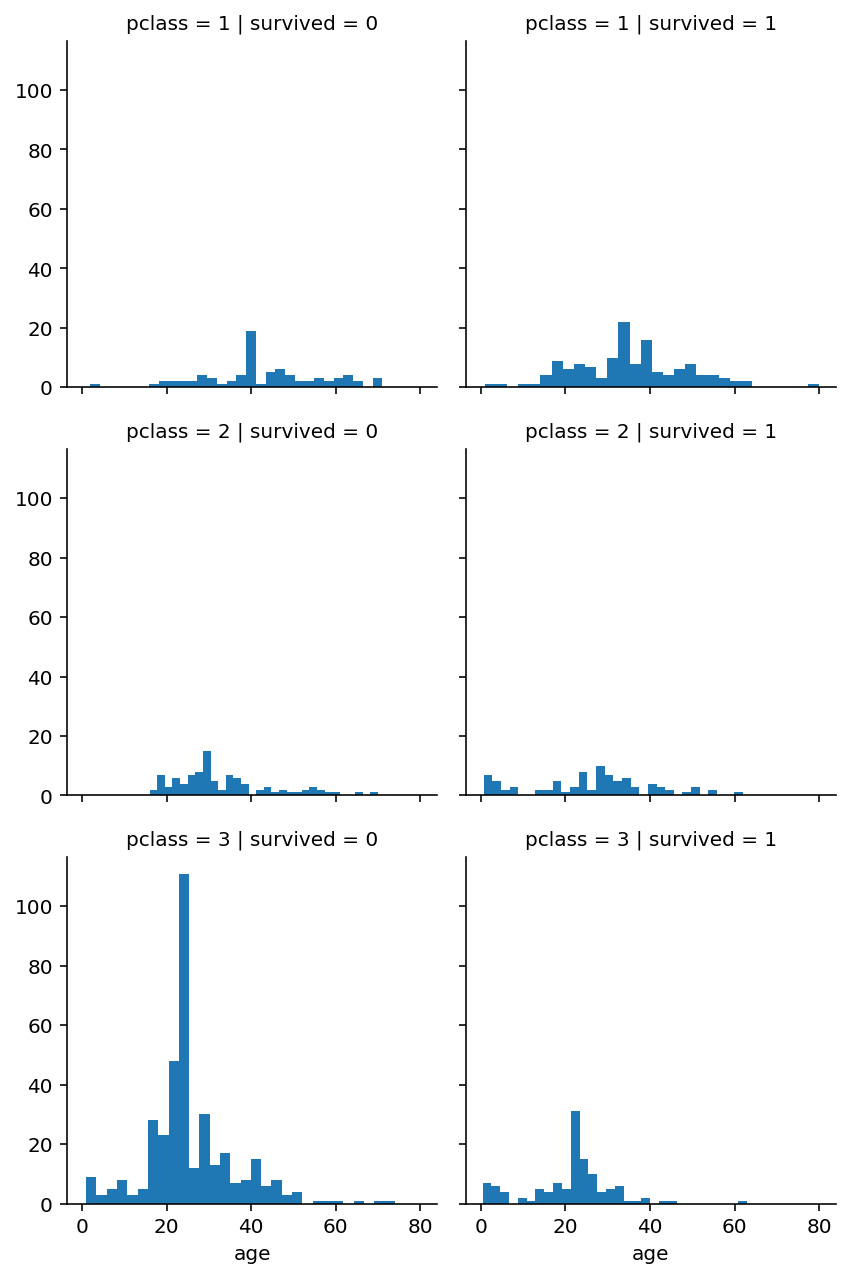

In [67]:
# FacetGrid可以直接生成多个子图，row,col参数表明根据哪行哪列分开，map函数的第一个参数是绘图函数，后面的参数是传给这个绘图函数的参数
sns.FacetGrid(df,col='survived',row='pclass').map(plt.hist,'age',bins=30)

### 连续变量用pd.cut离散化，分区间

In [68]:
df['age_band'] = pd.cut(df['age'],4)
df.head()

,pclass,sex,survived,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,age_band
0,3,male,0,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False,"(20.315, 40.21]"
1,1,female,1,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False,"(20.315, 40.21]"
2,3,female,1,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True,"(20.315, 40.21]"
3,1,female,1,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False,"(20.315, 40.21]"
4,3,male,0,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True,"(20.315, 40.21]"


In [69]:
# 获得各区间数量
df.age_band.value_counts()

(20.315, 40.21]    562
(0.34, 20.315]     179
(40.21, 60.105]    128
(60.105, 80.0]      22
Name: age_band, dtype: int64

In [73]:
# 各年龄区间总人数
df.pivot_table(values='survived',index='age_band',aggfunc='count')

,survived
age_band,
"(0.34, 20.315]",179
"(20.315, 40.21]",562
"(40.21, 60.105]",128
"(60.105, 80.0]",22


### 查看各个年龄区间的生还概率

In [74]:
df[['age_band','survived']].groupby('age_band').mean()

,survived
age_band,
"(0.34, 20.315]",0.458101
"(20.315, 40.21]",0.364769
"(40.21, 60.105]",0.390625
"(60.105, 80.0]",0.227273


Text(0.5, 1.0, '中文')

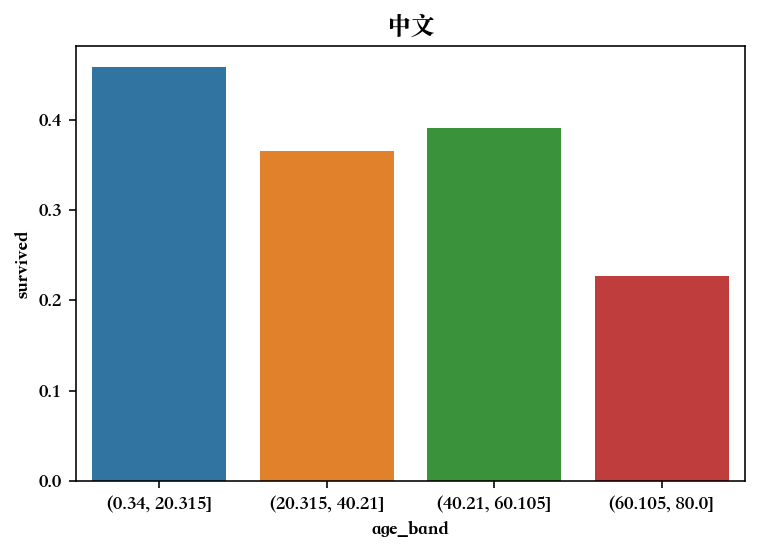

In [97]:
sns.barplot(data=df,x='age_band',y='survived',ci=None)

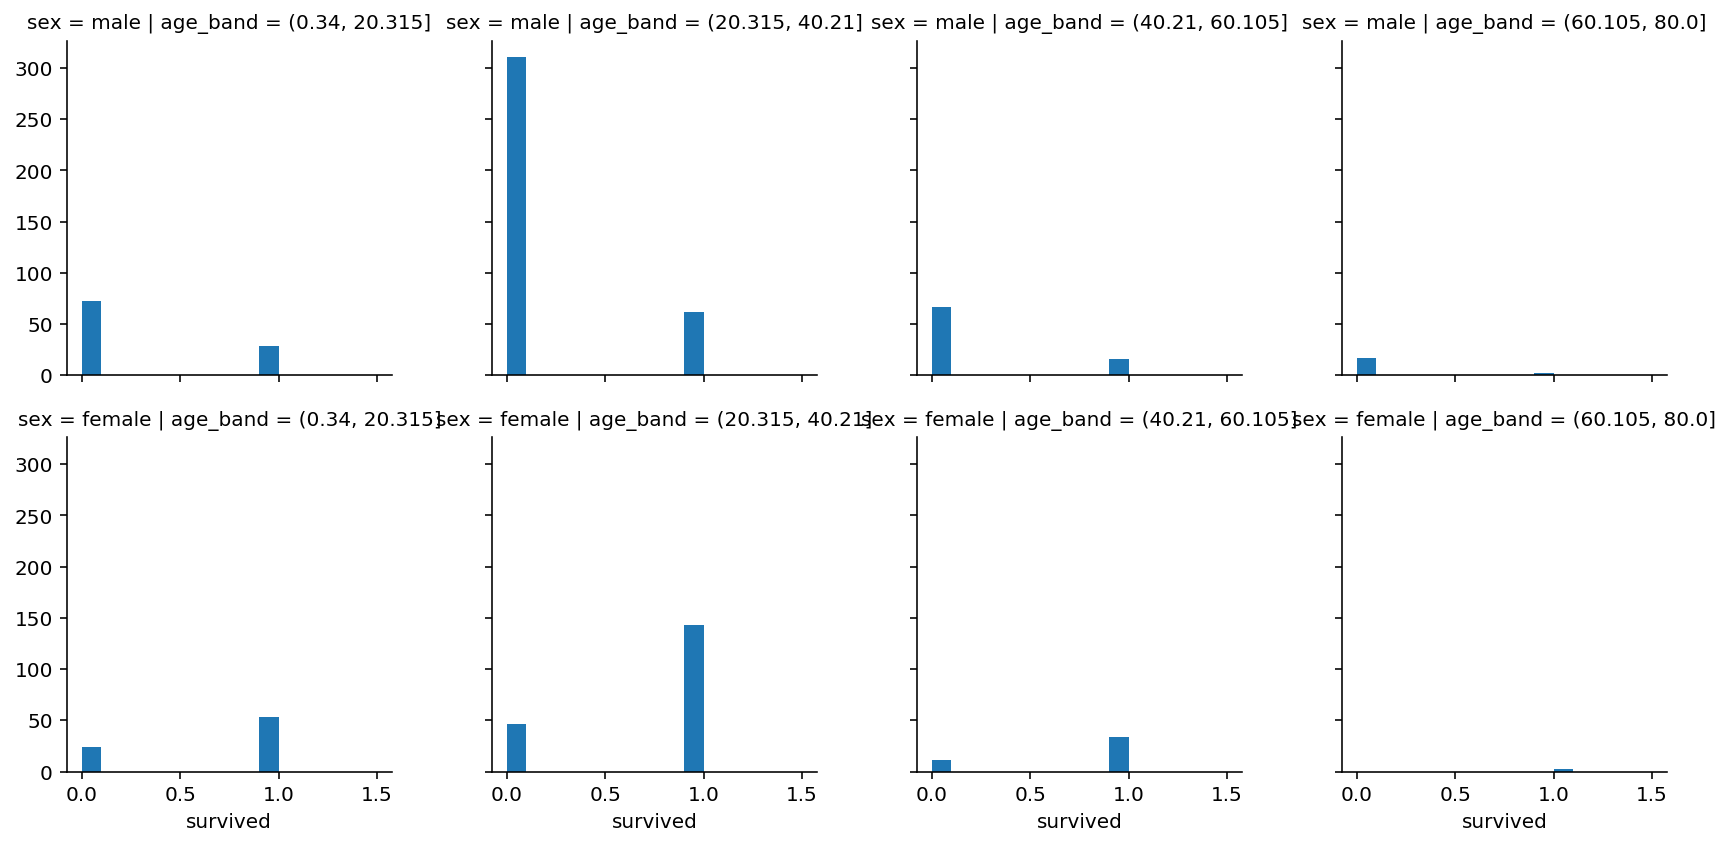

In [80]:
sns.FacetGrid(df,col='age_band',row='sex').map(plt.hist,'survived')

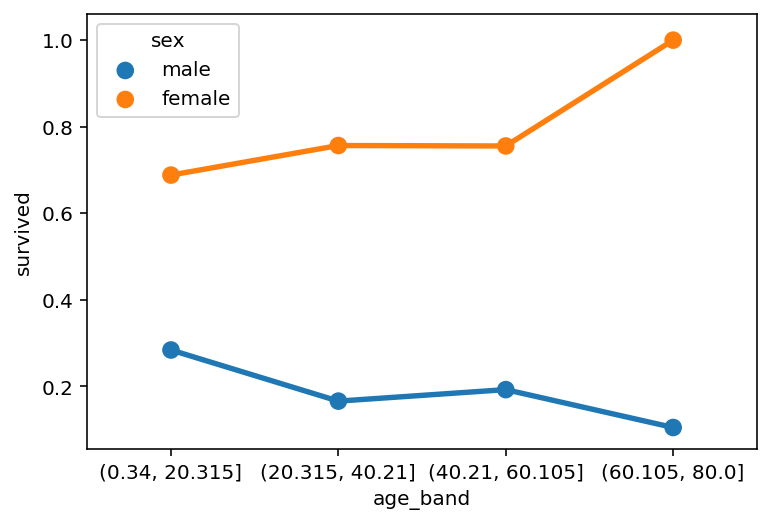

In [92]:
sns.pointplot(data=df,hue='sex',y='survived',x='age_band',ci=None)

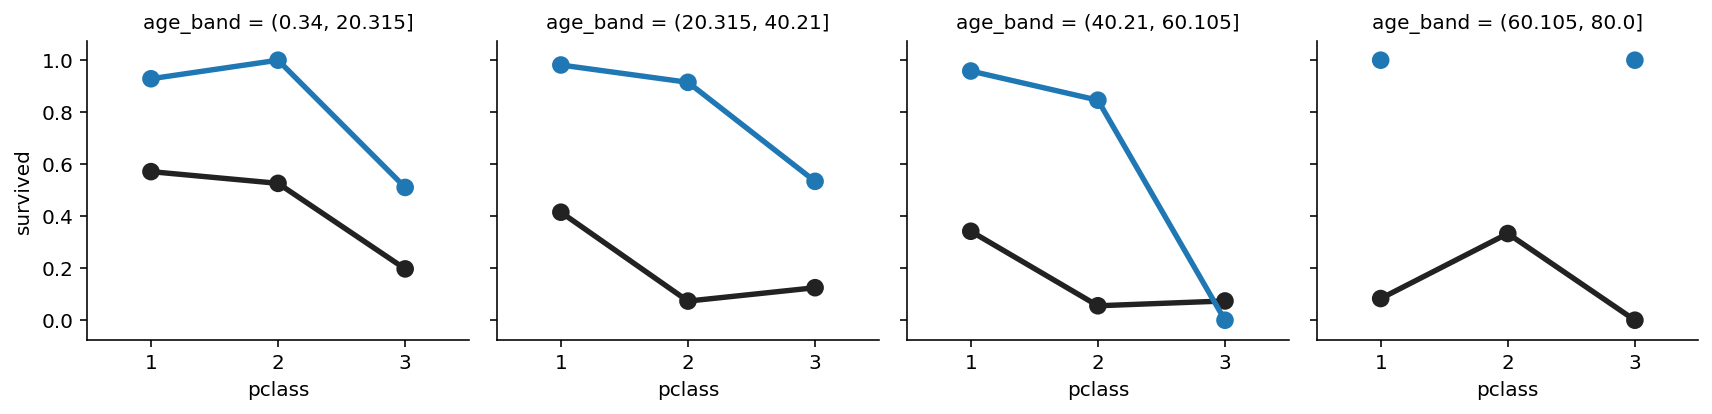

In [87]:
sns.FacetGrid(df,col='age_band').map(sns.pointplot,'pclass','survived','sex',ci=None)

不同年龄区间，pclass，sex和生还率的对照图

# 四、预测

In [142]:
df.head()

,pclass,sex,survived,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,3,0,0,22.0,1,0,7.2500,0,Third,man,True,NaN,Southampton,no,False
1,1,1,1,38.0,1,0,71.2833,1,First,woman,False,C,Cherbourg,yes,False
2,3,1,1,26.0,0,0,7.9250,0,Third,woman,False,NaN,Southampton,yes,True
3,1,1,1,35.0,1,0,53.1000,0,First,woman,False,C,Southampton,yes,False
4,3,0,0,35.0,0,0,8.0500,0,Third,man,True,NaN,Southampton,no,True


In [158]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.preprocessing import StandardScaler

In [146]:
# 特征选择
factors=['pclass','sex','age','sibsp','parch','fare','embarked']

In [147]:
x_train, x_test, y_train, y_test = train_test_split(df[factors], df["survived"], test_size = 0.3, train_size = 0.7, random_state = 1)

In [148]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

#### linear regression

In [154]:
lr = LinearRegression()
lr.fit(x_train,y_train)
y_predict = lr.predict(x_test)
print('score ',lr.score(x_test,y_test))

score  0.32472745085650123


In [155]:
y_predict[y_predict>0.5]=1
y_predict[y_predict<=0.5]=0
print('correct rate: ',sum(y_predict[y_predict==y_test])/len(y_test))

correct rate:  0.2835820895522388


#### random forest

In [232]:
from sklearn.ensemble import RandomForestClassifier
# n_estimators表示有几棵树，min_samples_split表示树的深度
rfc = RandomForestClassifier(random_state = 1, n_estimators = 55, min_samples_split = 8, min_samples_leaf = 2)

# k折验证
kf = KFold(n_splits=3,random_state=1)
scores = cross_val_score(rfc,df[factors],df['survived'],cv=kf)
scores.mean()

0.8260381593714926

#### 特征工程

In [204]:
# 增加familySize
df['familySize']=df['parch']+df['sibsp']
factors = ['pclass','sex','age','sibsp','parch','fare','embarked','familySize']

In [205]:
from sklearn.feature_selection import SelectKBest, f_classif

([<matplotlib.axis.XTick at 0x1a3721d1d0>,
 <a list of 8 Text xticklabel objects>)

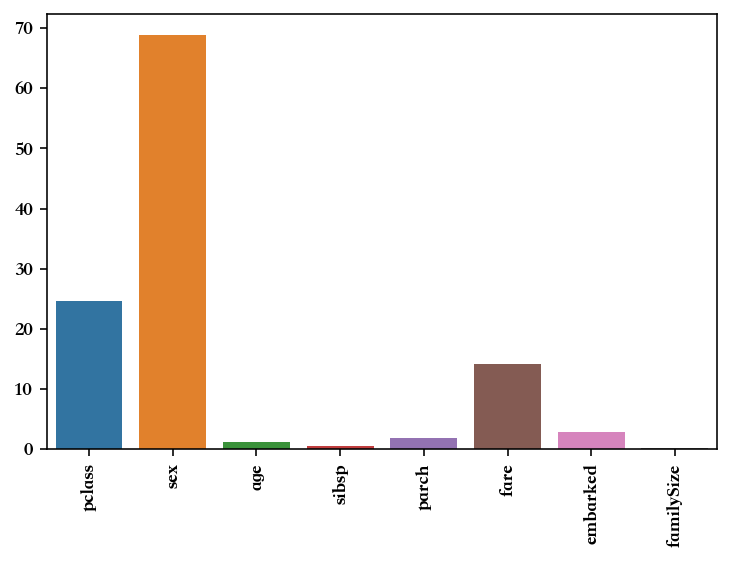

In [206]:
selector = SelectKBest(f_classif, k = 5)
selector.fit(df[factors], df["survived"])
scores = -np.log10(selector.pvalues_)
sns.barplot(factors, scores)
plt.xticks(range(len(factors)), factors, rotation = "vertical")

根据柱状图看，影响因子最大的特征是sex，其次是pclass，fare，embarked

In [235]:
predictors=['pclass','sex','fare','embarked']
rfc = RandomForestClassifier(random_state = 1, n_estimators = 65, min_samples_split = 10, min_samples_leaf = 2)
kf = KFold(n_splits=3,random_state=1)
scores = cross_val_score(rfc, df[predictors], df["survived"], cv = kf)
print(scores.mean())

0.8125701459034792


做特征选择并没有提升效果……毕竟这里总的特征数也不多，其实不是很有必要

#### boosting

In [236]:
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.linear_model import LogisticRegression